# Use of a Neural-Network for Constitutive Law

To allow inline pictures, run the following block

In [1]:
%matplotlib inline

Import all the useful libraries before first run
We need here the classic ones such as:
- math
- numpy
- pandas
- matplotlib

And for the Neural Network, we also need to import parts of the keras module of TensorFlow

In [2]:
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the test database

Read the Test database

In [3]:
dataPath = '.'
read = np.load(dataPath + '/DatatestWithDerivatives.npz')
testData = read['testData']
nrows = testData.shape[0]

In [4]:
eps_test = testData[:,0].reshape(nrows,1)
epsp_test = testData[:,1].reshape(nrows,1)
T_test = testData[:,2].reshape(nrows,1)
sig_test = testData[:,3].reshape(nrows,1)

 ## Load the NN parameters

In [5]:
ANN_name = '3-15-7-1-sigmoid'
#ANN_name = '3-5-3-1-sigmoid'
#ANN_name = '3-7-4-1-sigmoid'
#ANN_name = '3-9-5-1-sigmoid'
#ANN_name = '3-11-5-1-tanh'
#ANN_name = '3-5-3-1-tanh'
#ANN_name = '3-7-4-1-tanh'
#ANN_name = '3-9-5-1-tanh'

#ANN_name = '3-11-5-1-tanh'
NN = np.load(dataPath + '/' + ANN_name + '.npz')
print (NN.files)
w1 = NN['w1']
w2 = NN['w2']
w3 = NN['w3']
b1 = NN['b1']
b2 = NN['b2']
b3 = NN['b3']
minEntries = NN['minEntries']
maxEntries = NN['maxEntries']
rangeEntries = maxEntries - minEntries
logBase = NN['logBase']
w1, b1, w2, b2, w3, b3, minEntries, maxEntries, rangeEntries, logBase

['logBase', 'minEntries', 'maxEntries', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3']


(array([[-1.71193019e-01, -4.98235881e-01,  1.57230926e+00],
        [-1.82183892e-01, -2.79642552e-01,  1.38154745e+00],
        [-1.21008851e-01, -9.36221778e-02, -1.28485608e+00],
        [ 6.77952528e-01,  7.85129726e-01, -3.60040736e+00],
        [-8.22493362e+00,  1.02857426e-01, -1.17000186e+00],
        [-2.62212038e-01, -3.70604903e-01,  1.53059375e+00],
        [ 3.63313168e-01,  3.07944298e-01, -1.73980820e+00],
        [-1.71282619e-01, -9.36020970e-01, -7.00896144e-01],
        [-2.93405890e+00,  2.49693431e-02, -8.18501532e-01],
        [-2.98778355e-01, -5.17931700e-01, -7.58085251e+00],
        [ 1.17702794e+00, -3.08994055e-01, -1.68417966e+00],
        [-2.31339216e-01, -2.90423155e-01,  1.50245142e+00],
        [ 2.35784103e+02, -9.92930010e-02,  7.60096788e-01],
        [-2.33444443e+01,  1.64729804e-01, -9.49119210e-01],
        [ 3.29279006e-01,  5.42672016e-02, -1.55521262e+00]], dtype=float32),
 array([[-0.5497108 ],
        [-1.0076679 ],
        [ 1.146429  ],

## Reshape data

In [6]:
epsp_test = np.log(epsp_test / logBase)
inputTest = (np.hstack([eps_test, epsp_test, T_test]) - np.array(minEntries)[0:3]) / np.array(rangeEntries)[0:3]
inputTest

array([[0.64999785, 0.90552119, 0.65628871],
       [0.77199114, 0.8999689 , 0.45541125],
       [0.64433951, 0.99445344, 0.11009941],
       ...,
       [0.75192854, 0.99520977, 0.75841439],
       [0.74276917, 0.88747863, 0.12681504],
       [0.68998248, 0.88707664, 0.5388862 ]])

Computes the target

In [7]:
def tanh2Layers(inputData):
    l1 = w1.dot(inputData) + b1
    f1 = np.tanh(l1)
    l2 = w2.dot(f1) + b2
    f2 = np.tanh(l2)
    sigP = w3.dot(f2) + b3
    SigmaNN = sigP * rangeEntries[3] + minEntries[3]
    return SigmaNN

In [8]:
def sigmoid2Layers(inputData):
    l1 = w1.dot(inputData) + b1
    f1 = 1/(1 + np.exp(-l1))
    l2 = w2.dot(f1) + b2
    f2 = 1/( 1 +np.exp(-l2))
    sigP = w3.dot(f2) + b3
    SigmaNN = sigP * rangeEntries[3] + minEntries[3]
    return SigmaNN

Setup data

In [9]:
inp = inputTest.T
sig = sig_test
#inp, sig

Rebuild the real $\sigma$

In [10]:
if ('tanh' in ANN_name) : SigmaNN = tanh2Layers(inp)
elif ('sigmoid' in ANN_name) : SigmaNN = sigmoid2Layers(inp)
else : SigmaNN = 0
SigmaNN

array([[1232.2282292 , 1335.3603057 , 1470.46979899, ..., 1208.21439896,
        1465.07933384, 1287.15287545]])

In [11]:
# Computes the error
error = np.abs(SigmaNN.T - sig)/sig
print("Min error is: %8.7f %%" %(np.min(error)*100))
print("Max error is: %8.7f %%" %(np.max(error)*100))
print("Mean error is: %8.7f %%" %(np.mean(error)*100))
errorSort = np.sort(error, axis=0)
largeErrors = errorSort[errorSort > 5/1000]
print(len(largeErrors),'/',len(error),'points have errors > 0.5%\n')

# Display info for large errors
for err in largeErrors[::-1]:
    loc = np.where(error == err)[0][0]
    print('err= %5.3f %% for eps= %5.3E, epsp= %5.3E, T= %5.2f' %(error[loc][0]*100, eps_test[loc][0], math.exp(epsp_test[loc][0]), T_test[loc][0]))

Min error is: 0.0000022 %
Max error is: 0.0403637 %
Mean error is: 0.0104986 %
0 / 5000 points have errors > 0.5%



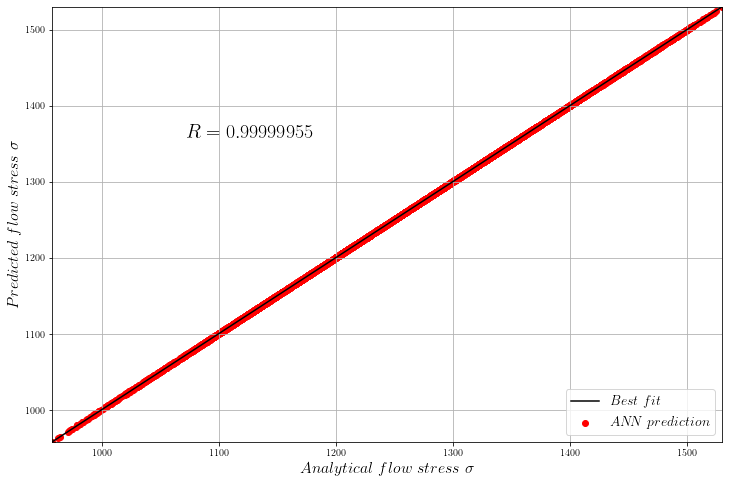

In [12]:
num = np.sum((sig-np.mean(sig)).T*(SigmaNN-np.mean(SigmaNN)))
den = math.sqrt(np.sum((sig-np.mean(sig)).T**2)*np.sum((SigmaNN-np.mean(SigmaNN))**2))
R = num/den
#np.mean(np.abs(((NNoutput+1)-(predictedOutput+1))/(NNoutput+1)))*100
plt.figure(figsize = (12, 8))
plt.rc('text', usetex = True)
plt.scatter(sig, SigmaNN, color='red', label="$AN\!N\ prediction$")
plt.plot([np.min(sig),np.max(sig)], [np.min(sig),np.max(sig)], color = 'black', label='$Best\ fit$')
plt.xlim(np.min(sig), np.max(sig))
plt.ylim(np.min(sig), np.max(sig))
plt.grid()
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Analytical\ flow\ stress\ \sigma$', fontsize = 16)
plt.ylabel(r'$Predicted\ flow\ stress\ \sigma$', fontsize = 16)
plt.text(np.min(sig) + 0.2*(np.max(sig)-np.min(sig)), np.min(sig)+ 0.7*(np.max(sig)-np.min(sig)), '$R = %.8f$' % (R), fontsize=20)
#plt.title(r'$Map\ of\ errors\ \varepsilon^{p} / T$', fontsize = 20)
#if (saveFigures) : plt.savefig(dataPath + '/' + 'NN-' + model.name + '-error-sig.svg', bbox_inches = 'tight', pad_inches = 0)
plt.show() 

In [13]:
levelsT = ['$> 1.00 \%$','$0.50 - 1.00 \%$','$0.25 - 0.50 \%$','$0.10 - 0.25 \%$','$< 0.10 \%$']
levelsC = [0.01, 0.005, 0.0025, 0.001]

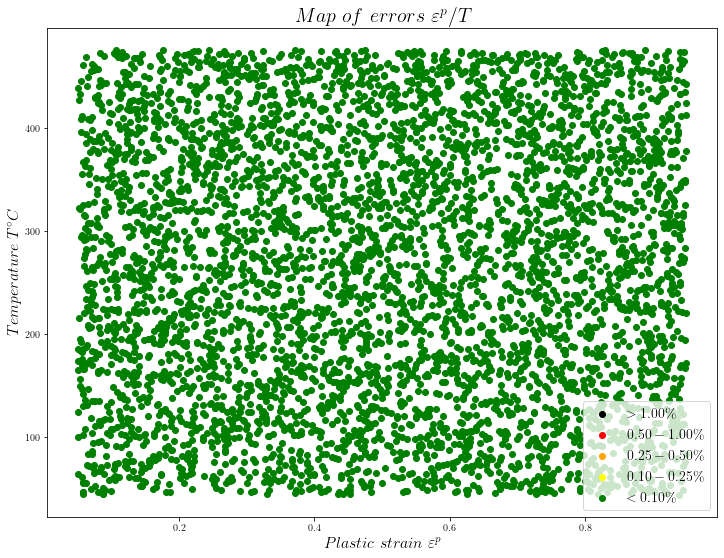

In [14]:
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], T_test[error >= levelsC[0]], color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
plt.ylabel(r'$Temperature\ T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \varepsilon^{p} / T$', fontsize = 20)
plt.show()

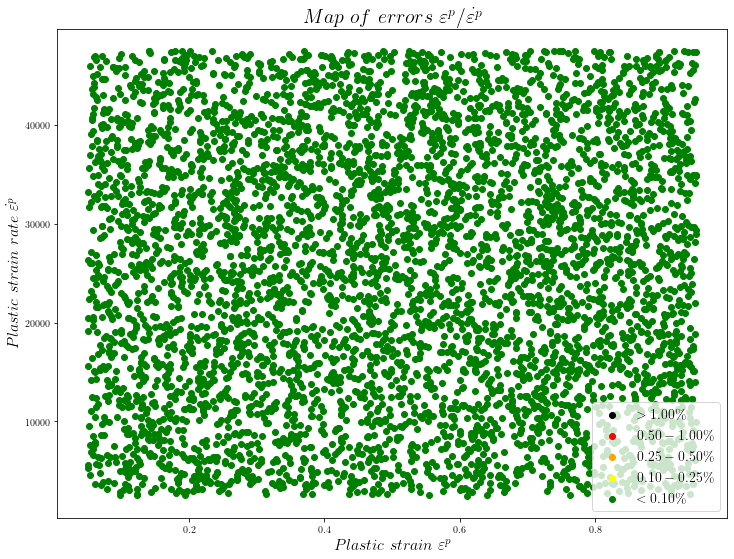

In [15]:
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
plt.ylabel(r'$Plastic\ strain\ rate\ \dot{\varepsilon^{p}}$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \varepsilon^{p} / \dot{\varepsilon^{p}}$', fontsize = 20)
plt.show()

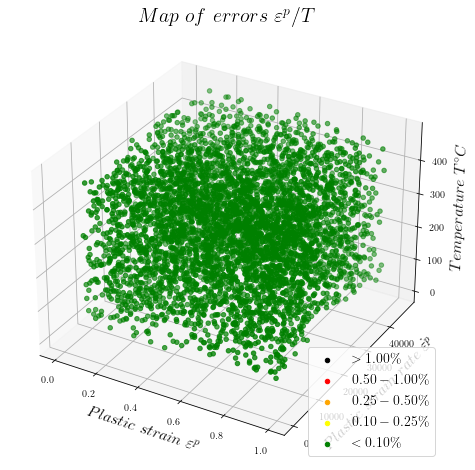

In [16]:
fig = plt.figure(figsize = (8, 8))
plt.rc('text', usetex = True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), T_test[error >= levelsC[0]], color='black', label=levelsT[0])
ax.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
ax.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
ax.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
ax.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
ax.set_xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
ax.set_ylabel(r'$Plastic\ strain\ rate\ \dot{\varepsilon^{p}}$', fontsize = 16)
ax.set_zlabel(r'$Temperature\ T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \varepsilon^{p} / T$', fontsize = 20)
plt.show()

In [17]:
loc = np.argmin(error)
#loc = 200
dx = 1e-6
inp = np.array([testData[loc,0], testData[loc,1], testData[loc,2]])
sig = testData[loc,3]
sigEps = testData[loc,4]
sigEpsp = testData[loc,5]
sigT = testData[loc,6]

In [18]:
inp, loc

(array([4.49375973e-01, 3.40018673e+04, 9.58250682e+01]), 24)

In [19]:
inp0 = inp.copy()
inp = np.vstack([inp,inp0 + [[dx,0,0]]])
inp = np.vstack([inp,inp0 + [[0,dx,0]]])
inp = np.vstack([inp,inp0 + [[0,0,dx]]])
inp

array([[4.49375973e-01, 3.40018673e+04, 9.58250682e+01],
       [4.49376973e-01, 3.40018673e+04, 9.58250682e+01],
       [4.49375973e-01, 3.40018673e+04, 9.58250682e+01],
       [4.49375973e-01, 3.40018673e+04, 9.58250692e+01]])

In [20]:
for i in range(4): inp[i,1] = np.log(inp[i,1]/logBase)
inp

array([[ 0.44937597, 10.43417072, 95.82506821],
       [ 0.44937697, 10.43417072, 95.82506821],
       [ 0.44937597, 10.43417072, 95.82506821],
       [ 0.44937597, 10.43417072, 95.82506921]])

In [21]:
inp = (inp - minEntries[0:3]) / rangeEntries[0:3]
inp

array([[0.44937597, 0.96436086, 0.15796889],
       [0.44937697, 0.96436086, 0.15796889],
       [0.44937597, 0.96436086, 0.15796889],
       [0.44937597, 0.96436086, 0.15796889]])

In [22]:
if ('tanh' in ANN_name) : SigmaNN = tanh2Layers(inp.T)
elif ('sigmoid' in ANN_name) : SigmaNN = sigmoid2Layers(inp.T)
else : SigmaNN = 0
SigmaNN

array([[1413.24752504, 1413.24773591, 1413.24752504, 1413.24752426]])

In [23]:
SigmaNN[0][0], sig, abs((SigmaNN[0][0] - sig)/sig)

(1413.2475250368198, 1413.2475557538698, 2.1735080998051432e-08)

In [24]:
sigEpsN = (SigmaNN[0][1]-SigmaNN[0][0])/dx
sigEpsN, sigEps, abs((sigEpsN - sigEps)/sigEps)

(210.8775956912723, 211.210468949166, 0.0015760263189123689)

In [25]:
sigEpspN = (SigmaNN[0][2]-SigmaNN[0][0])/dx
sigEpspN, sigEpsp, abs((sigEpspN - sigEpsp)/sigEpsp)

(0.0003369677870068699, 0.0003384849112498175, 0.004482103020030653)

In [26]:
sigTN = (SigmaNN[0][3]-SigmaNN[0][0])/dx
sigTN, sigT, abs((sigTN- sigT)/sigT)

(-0.7803234893799527, -0.7869030856524288, 0.008361380699150477)

## Dérivation directe

In [27]:
x = inp[0].reshape(3,1)
x

array([[0.44937597],
       [0.96436086],
       [0.15796889]])

In [28]:
def tanhPrime2Layers(x):
    w3v = w3.reshape(w3.shape[1],1)
    tanhx = np.tanh(w1.dot(x) + b1)
    p2 = w3v * (1 - np.tanh(w2.dot(tanhx) + b2)**2)
    p3 = (w2.T).dot(p2)
    p5 = p3 * (1 - tanhx**2)
    s = (w1.T).dot(p5)
    return s

In [29]:
def sigmoidPrime2Layers(x):
    w3v = w3.reshape(w3.shape[1],1)
    expx = np.exp(-(w1.dot(x) + b1))
    exp2 = np.exp(w2.dot(1/(1 + expx)) + b2)
    p1 = w3v*(exp2 / (1 + exp2)**2)
    p2 = expx / (1 + expx)**2
    s = (w1.T).dot((w2.T).dot(p1) * p2)
    return s

In [30]:
if ('tanh' in ANN_name) : s = tanhPrime2Layers(x)
elif ('sigmoid' in ANN_name) : s = sigmoidPrime2Layers(x)
else : s = 0
s

array([[ 0.21571946],
       [ 0.12683362],
       [-0.38315484]])

In [31]:
scaleOut = np.array([[rangeEntries[3]/rangeEntries[0]],[rangeEntries[3]/rangeEntries[1]],[rangeEntries[3]/rangeEntries[2]]])
scaleOut

array([[977.55571504],
       [ 90.34895996],
       [  2.03657441]])

In [32]:
scaled = s*scaleOut
scaled

array([[210.8777875 ],
       [ 11.45928556],
       [ -0.78032333]])

In [33]:
sigEpsNN = scaled[0][0]
print(sigEpsNN)
print('Num : ',sigEpsN, abs((sigEpsNN-sigEpsN)/sigEpsN))
print('Ana : ',sigEps, abs((sigEpsNN-sigEps)/sigEps))

210.87778749869534
Num :  210.8775956912723 9.095675736509179e-07
Ana :  211.210468949166 0.0015751181848411527


In [34]:
sigEpspNN = scaled[1][0]/testData[loc,1]
print(sigEpspNN)
print('Num : ',sigEpspN, abs((sigEpspNN-sigEpspN)/sigEpspN))
print('Ana : ',sigEpsp, abs((sigEpspNN-sigEpsp)/sigEpsp))

0.00033701930123735584
Num :  0.0003369677870068699 0.00015287583108019087
Ana :  0.0003384849112498175 0.0043299123941746365


In [35]:
sigTNN = scaled[2][0]
print(sigTNN)
print('Num : ',sigTN, abs((sigTNN-sigTN)/sigTN))
print('Ana : ',sigT, abs((sigTNN-sigT)/sigT))

-0.7803233329932046
Num :  -0.7803234893799527 2.0041271374668405e-07
Ana :  -0.7869030856524288 0.008361579436137228


In [36]:
if ('tanh' in ANN_name) : sp = tanhPrime2Layers(inputTest.T)
elif ('sigmoid' in ANN_name) : sp = sigmoidPrime2Layers(inputTest.T)
else : sp = 0
ss = sp*scaleOut

In [37]:
error = np.abs((ss[0,:] - testData[:,4]) / testData[:,4])
"EPS", error.max(), error.min(), error.mean()

('EPS', 0.01806216532722194, 2.3705629347774093e-07, 0.002379540107767862)

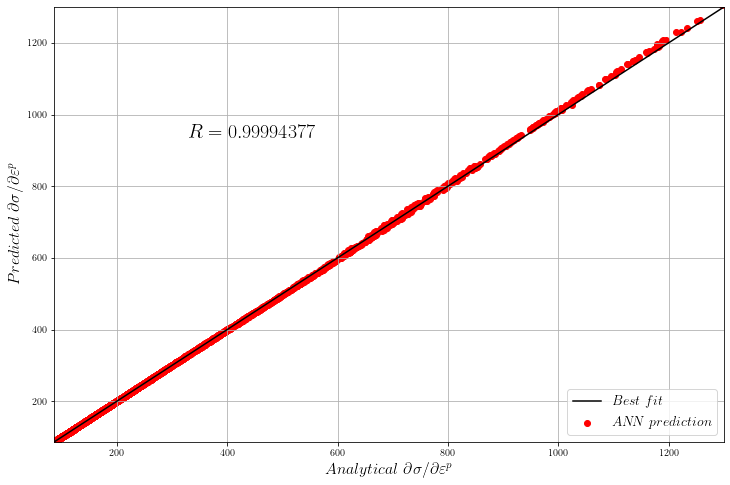

In [38]:
v1 = ss[0,:]
v2 = testData[:,4]
num = np.sum((v2-np.mean(v2))*(v1-np.mean(v1)))
den = math.sqrt(np.sum((v2-np.mean(v2))**2)*np.sum((v1-np.mean(v1))**2))
R = num/den
#np.mean(np.abs(((NNoutput+1)-(predictedOutput+1))/(NNoutput+1)))*100
plt.figure(figsize = (12, 8))
plt.rc('text', usetex = True)
plt.scatter(v2, v1, color='red', label="$AN\!N\ prediction$")
plt.plot([np.min(v2),np.max(v2)], [np.min(v2),np.max(v2)], color = 'black', label='$Best\ fit$')
plt.xlim(np.min(v2), np.max(v2))
plt.ylim(np.min(v2), np.max(v2))
plt.grid()
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Analytical\ \partial\sigma/\partial\varepsilon^{p}$', fontsize = 16)
plt.ylabel(r'$Predicted\ \partial\sigma/\partial\varepsilon^{p}$', fontsize = 16)
plt.text(np.min(v2) + 0.2*(np.max(v2)-np.min(v2)), np.min(v2)+ 0.7*(np.max(v2)-np.min(v2)), '$R = %.8f$' % (R), fontsize=20)
#plt.title(r'$Map\ of\ errors\ \varepsilon^{p} / T$', fontsize = 20)
plt.savefig(ANN_name + 'R-sig-eps.svg')
plt.show() 

In [39]:
levelsT = ['$> 5.00 \%$','$3.00 - 5.00 \%$','$1.00 - 3.00 \%$','$0.50 - 1.00 \%$','$< 0.50 \%$']
levelsC = [0.05, 0.03, 0.01, 0.005]

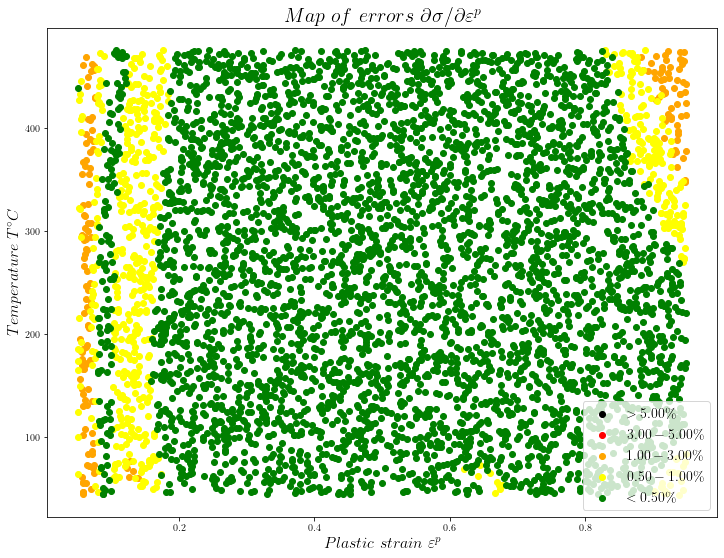

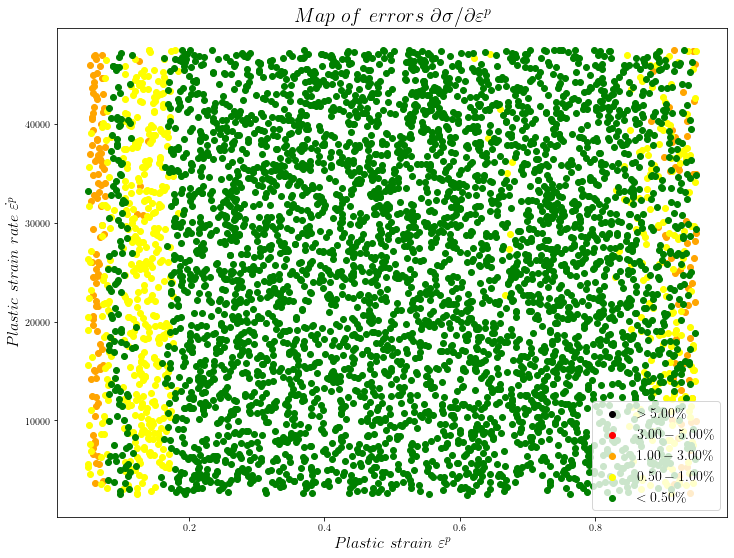

In [40]:
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], T_test[error >= levelsC[0]], color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
plt.ylabel(r'$Temperature\ T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \partial\sigma/\partial\varepsilon^{p}$', fontsize = 20)
plt.show()
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
plt.ylabel(r'$Plastic\ strain\ rate\ \dot{\varepsilon^{p}}$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \partial\sigma/\partial\varepsilon^{p}$', fontsize = 20)
plt.show()

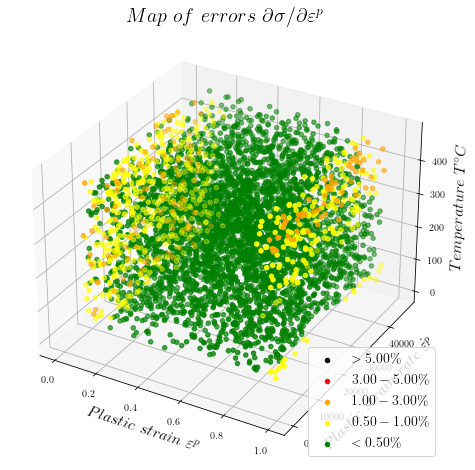

In [41]:
fig = plt.figure(figsize = (8, 8))
plt.rc('text', usetex = True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), T_test[error >= levelsC[0]], color='black', label=levelsT[0])
ax.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
ax.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
ax.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
ax.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
ax.set_xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
ax.set_ylabel(r'$Plastic\ strain\ rate\ \dot{\varepsilon^{p}}$', fontsize = 16)
ax.set_zlabel(r'$Temperature\ T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \partial\sigma/\partial\varepsilon^{p}$', fontsize = 20)
plt.show()

In [42]:
nnvals = ss[1]/testData[:,1]
error = np.abs((nnvals - testData[:,5]) / testData[:,5])
"EPSP", error.max(), error.min(), error.mean()

('EPSP', 0.008845799198022959, 2.2026122952182023e-07, 0.0018622156421753203)

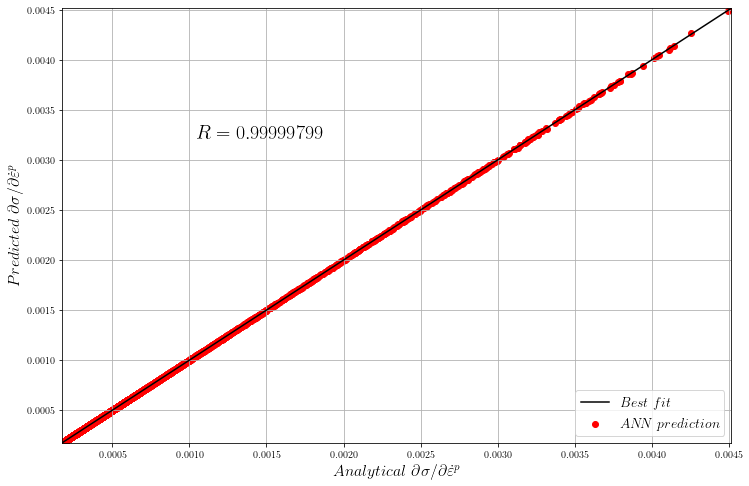

In [43]:
v1 = ss[1]/testData[:,1]
v2 = testData[:,5]
num = np.sum((v2-np.mean(v2))*(v1-np.mean(v1)))
den = math.sqrt(np.sum((v2-np.mean(v2))**2)*np.sum((v1-np.mean(v1))**2))
R = num/den
#np.mean(np.abs(((NNoutput+1)-(predictedOutput+1))/(NNoutput+1)))*100
plt.figure(figsize = (12, 8))
plt.rc('text', usetex = True)
plt.scatter(v2, v1, color='red', label="$AN\!N\ prediction$")
plt.plot([np.min(v2),np.max(v2)], [np.min(v2),np.max(v2)], color = 'black', label='$Best\ fit$')
plt.xlim(np.min(v2), np.max(v2))
plt.ylim(np.min(v2), np.max(v2))
plt.grid()
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Analytical\ \partial\sigma/\partial\dot{\varepsilon}^{p}$', fontsize = 16)
plt.ylabel(r'$Predicted\ \partial\sigma/\partial\dot{\varepsilon}^{p}$', fontsize = 16)
plt.text(np.min(v2) + 0.2*(np.max(v2)-np.min(v2)), np.min(v2)+ 0.7*(np.max(v2)-np.min(v2)), '$R = %.8f$' % (R), fontsize=20)
plt.savefig(ANN_name + 'R-sig-epsp.svg')
plt.show() 

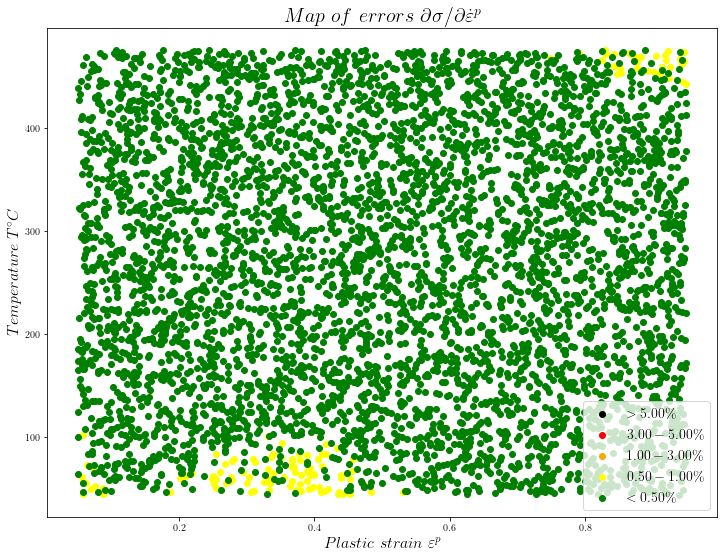

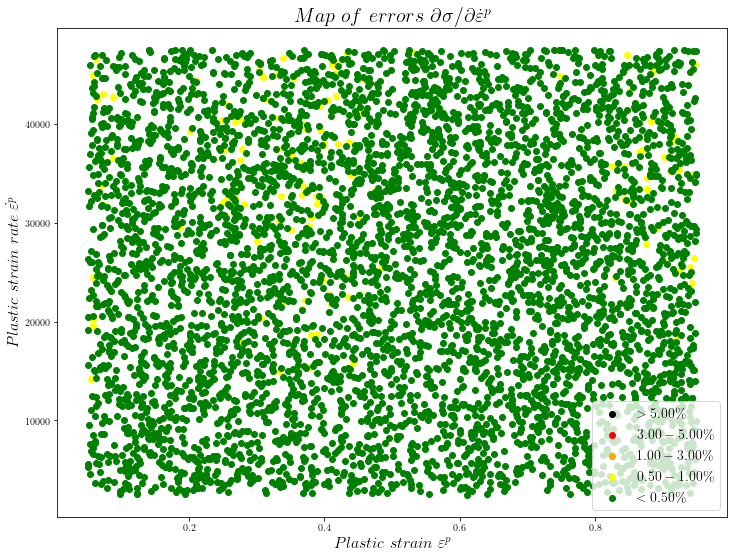

In [44]:
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], T_test[error >= levelsC[0]], color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
plt.ylabel(r'$Temperature\ T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \partial\sigma/\partial\dot{\varepsilon}^{p}$', fontsize = 20)
plt.show()
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
plt.ylabel(r'$Plastic\ strain\ rate\ \dot{\varepsilon^{p}}$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \partial\sigma/\partial\dot{\varepsilon}^{p}$', fontsize = 20)
plt.show()

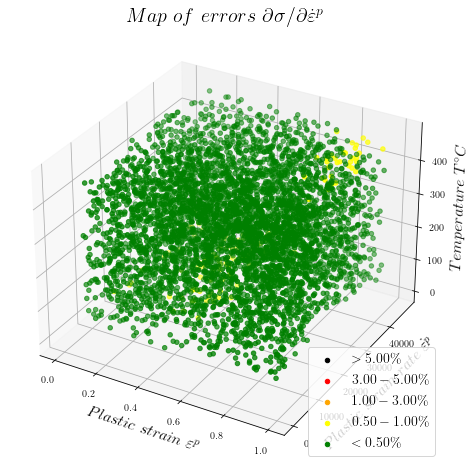

In [45]:
fig = plt.figure(figsize = (8, 8))
plt.rc('text', usetex = True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), T_test[error >= levelsC[0]], color='black', label=levelsT[0])
ax.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
ax.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
ax.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
ax.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
ax.set_xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
ax.set_ylabel(r'$Plastic\ strain\ rate\ \dot{\varepsilon^{p}}$', fontsize = 16)
ax.set_zlabel(r'$Temperature\ T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \partial\sigma/\partial\dot{\varepsilon}^{p}$', fontsize = 20)
plt.show()

In [46]:
nnvals = ss[2]
error = np.abs((nnvals - testData[:,6]) / testData[:,6])
"T", error.max(), error.min(), error.mean()

('T', 0.020736253015271936, 5.306895168413769e-07, 0.0024809304495987112)

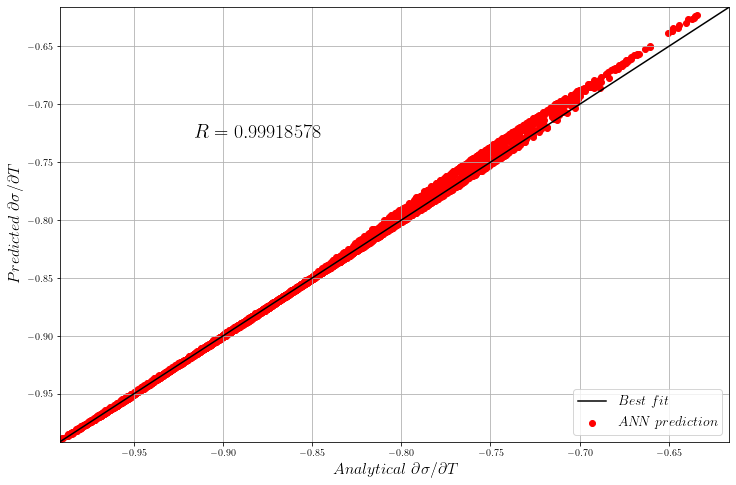

In [47]:
v1 = ss[2]
v2 = testData[:,6]
num = np.sum((v2-np.mean(v2))*(v1-np.mean(v1)))
den = math.sqrt(np.sum((v2-np.mean(v2))**2)*np.sum((v1-np.mean(v1))**2))
R = num/den
#np.mean(np.abs(((NNoutput+1)-(predictedOutput+1))/(NNoutput+1)))*100
plt.figure(figsize = (12, 8))
plt.rc('text', usetex = True)
plt.scatter(v2, v1, color='red', label="$AN\!N\ prediction$")
plt.plot([np.min(v2),np.max(v2)], [np.min(v2),np.max(v2)], color = 'black', label='$Best\ fit$')
plt.xlim(np.min(v2), np.max(v2))
plt.ylim(np.min(v2), np.max(v2))
plt.grid()
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Analytical\ \partial\sigma/\partial T$', fontsize = 16)
plt.ylabel(r'$Predicted\ \partial\sigma/\partial T$', fontsize = 16)
plt.text(np.min(v2) + 0.2*(np.max(v2)-np.min(v2)), np.min(v2)+ 0.7*(np.max(v2)-np.min(v2)), '$R = %.8f$' % (R), fontsize=20)
#plt.title(r'$Map\ of\ errors\ \varepsilon^{p} / T$', fontsize = 20)
#if (saveFigures) : plt.savefig(dataPath + '/' + 'NN-' + model.name + '-error-sig.svg', bbox_inches = 'tight', pad_inches = 0)
plt.savefig(ANN_name + 'R-sig-T.svg')
plt.show() 

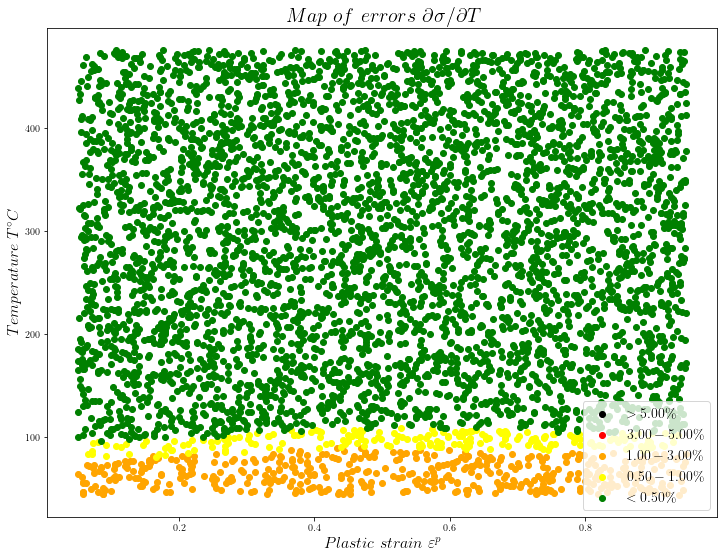

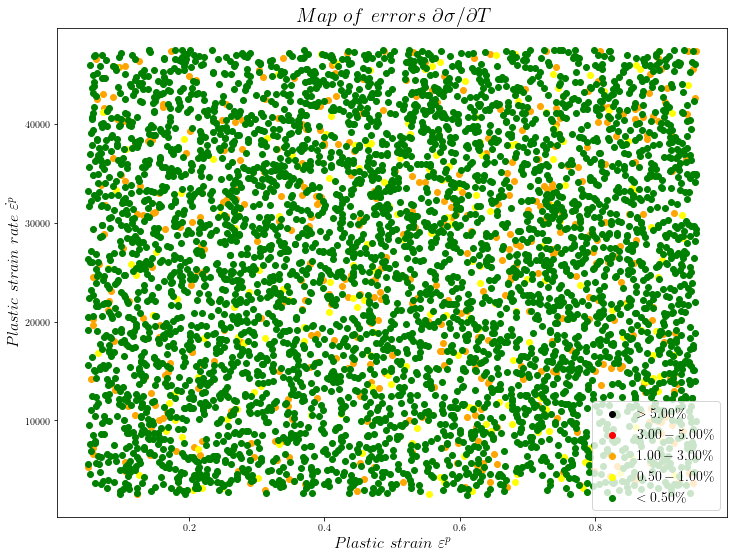

In [48]:
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], T_test[error >= levelsC[0]], color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
plt.ylabel(r'$Temperature\ T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \partial\sigma/\partial T$', fontsize = 20)
plt.show()
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
plt.ylabel(r'$Plastic\ strain\ rate\ \dot{\varepsilon^{p}}$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \partial\sigma/\partial T$', fontsize = 20)
plt.show()

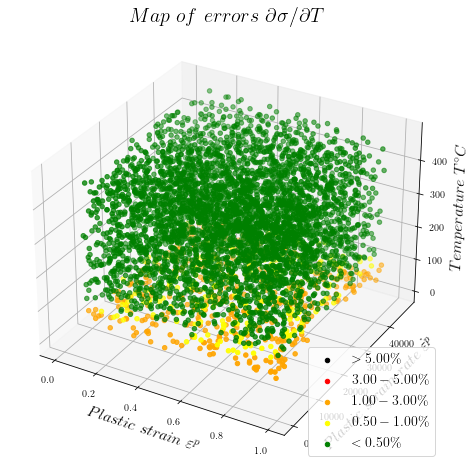

In [49]:
fig = plt.figure(figsize = (8, 8))
plt.rc('text', usetex = True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), T_test[error >= levelsC[0]], color='black', label=levelsT[0])
ax.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
ax.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
ax.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
ax.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
ax.set_xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
ax.set_ylabel(r'$Plastic\ strain\ rate\ \dot{\varepsilon^{p}}$', fontsize = 16)
ax.set_zlabel(r'$Temperature\ T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \partial\sigma/\partial T$', fontsize = 20)
plt.show()

In [50]:
TotalFrames = len(glob.glob(dataPath + '/' + ANN_name + '/ANN-*.npz'))
framesWide = 1000
emax = np.array([])
emin = np.array([])
emean = np.array([])
epmax = np.array([])
epmin = np.array([])
epmean = np.array([])
tmax = np.array([])
tmin = np.array([])
tmean = np.array([])
smax = np.array([])
smin = np.array([])
smean = np.array([])
for i in range(TotalFrames):
    nm = dataPath + '/' + ANN_name + '/ANN-' + str(i) + '.npz'
    NN = np.load(nm)
    w1 = NN['w1']
    w2 = NN['w2']
    w3 = NN['w3']
    b1 = NN['b1']
    b2 = NN['b2']
    b3 = NN['b3']
    minEntries = NN['minEntries']
    maxEntries = NN['maxEntries']
    rangeEntries = maxEntries - minEntries
    logBase = NN['logBase']
    if ('tanh' in ANN_name) : sp = tanhPrime2Layers(inputTest.T)
    elif ('sigmoid' in ANN_name) : sp = sigmoidPrime2Layers(inputTest.T)
    else : sp = 0
    ss = sp*scaleOut
    error = np.abs((ss[0,:] - testData[:,4]) / testData[:,4])
    emax=np.append(emax,error.max())
    emin=np.append(emin,error.min())
    emean=np.append(emean,error.mean())    
    error = np.abs((ss[1]/testData[:,1] - testData[:,5]) / testData[:,5])
    epmax=np.append(epmax,error.max())
    epmin=np.append(epmin,error.min())
    epmean=np.append(epmean,error.mean())    
    error = np.abs((ss[2] - testData[:,6]) / testData[:,6])
    tmax=np.append(tmax,error.max())
    tmin=np.append(tmin,error.min())
    tmean=np.append(tmean,error.mean())
    if ('tanh' in ANN_name) : sp = tanh2Layers(inputTest.T)
    elif ('sigmoid' in ANN_name) : sp = sigmoid2Layers(inputTest.T)
    else : sp = 0
    error = np.abs((sp[0,:] - testData[:,3]) / testData[:,3])
    smax=np.append(smax,error.max())
    smin=np.append(smin,error.min())
    smean=np.append(smean,error.mean())   

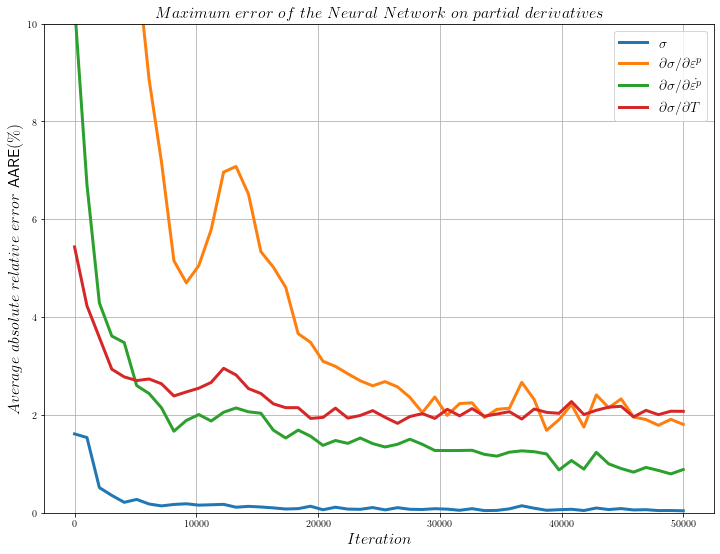

In [51]:
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
xx = np.linspace(1,TotalFrames*framesWide,TotalFrames)
plt.plot(xx,100*smax, label = r"$\sigma$",  linewidth = 3)
plt.plot(xx,100*emax, label = r"$\partial\sigma/\partial\varepsilon^p$",  linewidth = 3)
plt.plot(xx,100*epmax, label = r"$\partial\sigma/\partial\dot{\varepsilon^p}$",  linewidth = 3)
plt.plot(xx,100*tmax, label = r"$\partial\sigma/\partial T$",  linewidth = 3)
plt.grid()
plt.ylim(0, 10)
plt.xlabel(r'$Iteration$', fontsize = 16)
plt.ylabel(r'$Average\ absolute\ relative\ error\ $AARE$(\%)$', fontsize = 16)
plt.title(r'$Maximum\ error\ of\ the\ Neural\ Network\ on\ partial\ derivatives$', fontsize = 16)
plt.legend(loc = 'upper right',fancybox = True, numpoints = 1, fontsize = 14)
plt.savefig(ANN_name + 'max-error.svg')
plt.show()

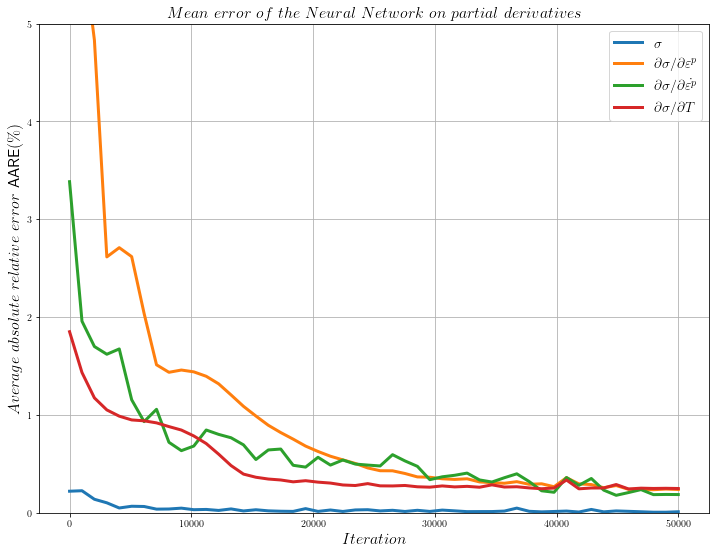

In [52]:
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
xx = np.linspace(1,TotalFrames*framesWide,TotalFrames)
plt.plot(xx,100*smean, label = r"$\sigma$",  linewidth = 3)
plt.plot(xx,100*emean, label = r"$\partial\sigma/\partial\varepsilon^p$",  linewidth = 3)
plt.plot(xx,100*epmean, label = r"$\partial\sigma/\partial\dot{\varepsilon^p}$",  linewidth = 3)
plt.plot(xx,100*tmean, label = r"$\partial\sigma/\partial T$",  linewidth = 3)
plt.grid()
plt.ylim(0, 5)
plt.xlabel(r'$Iteration$', fontsize = 16)
plt.ylabel(r'$Average\ absolute\ relative\ error\ $AARE$(\%)$', fontsize = 16)
plt.title(r'$Mean\ error\ of\ the\ Neural\ Network\ on\ partial\ derivatives$', fontsize = 16)
plt.legend(loc = 'upper right',fancybox = True, numpoints = 1, fontsize = 14)
plt.savefig(ANN_name + 'mean-error.svg')
plt.show()

In [53]:
file_object = open('compare.txt', 'a')
file_object.write(ANN_name+'\n')
file_object.write('smean: %5.3f \n' %(100*np.mean(smean[-6:-1])))
file_object.write('emean: %5.3f \n' %(100*np.mean(emean[-6:-1])))
file_object.write('epmean: %5.3f \n' %(100*np.mean(epmean[-6:-1])))
file_object.write('tmean: %5.3f \n' %(100*np.mean(tmean[-6:-1])))
file_object.write('smax: %5.3f \n' %(100*np.mean(smax[-6:-1])))
file_object.write('emax: %5.3f \n' %(100*np.mean(emax[-6:-1])))
file_object.write('epmax: %5.3f \n' %(100*np.mean(epmax[-6:-1])))
file_object.write('tmax: %5.3f \n' %(100*np.mean(tmax[-6:-1])))
file_object.close()

In [54]:
file_object = open('compare.csv', 'a')
file_object.write(ANN_name+';')
file_object.write('%5.3f;' %(100*np.mean(smean[-6:-1])))
file_object.write('%5.3f;' %(100*np.mean(emean[-6:-1])))
file_object.write('%5.3f;' %(100*np.mean(epmean[-6:-1])))
file_object.write('%5.3f;' %(100*np.mean(tmean[-6:-1])))
file_object.write('%5.3f;' %(100*np.mean(smax[-6:-1])))
file_object.write('%5.3f;' %(100*np.mean(emax[-6:-1])))
file_object.write('%5.3f;' %(100*np.mean(epmax[-6:-1])))
file_object.write('%5.3f\n' %(100*np.mean(tmax[-6:-1])))
file_object.close()